In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
from tensorflow.keras.metrics import Accuracy

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')


In [2]:
images = glob('train/*/*.jpg')
len(images)

210

In [3]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,train/benign/not_skin_cancer_00.jpg,benign
1,train/benign/not_skin_cancer_01.jpg,benign
2,train/benign/not_skin_cancer_04.jpg,benign
3,train/benign/not_skin_cancer_05.jpg,benign
4,train/benign/not_skin_cancer_06.jpg,benign


In [4]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,train/benign/not_skin_cancer_00.jpg,benign,0
1,train/benign/not_skin_cancer_01.jpg,benign,0
2,train/benign/not_skin_cancer_04.jpg,benign,0
3,train/benign/not_skin_cancer_05.jpg,benign,0
4,train/benign/not_skin_cancer_06.jpg,benign,0


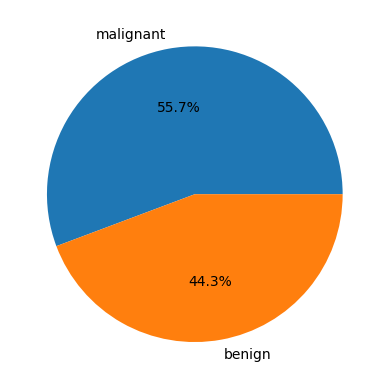

In [5]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()

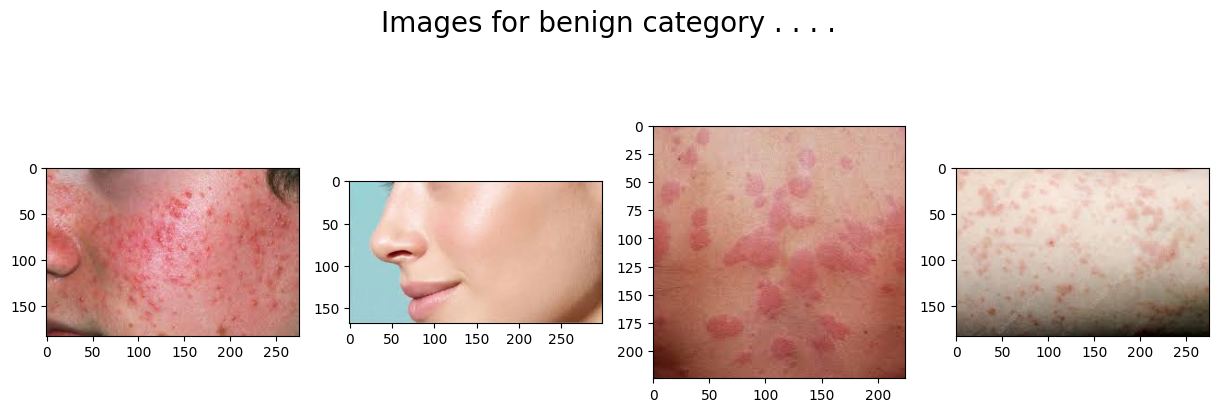

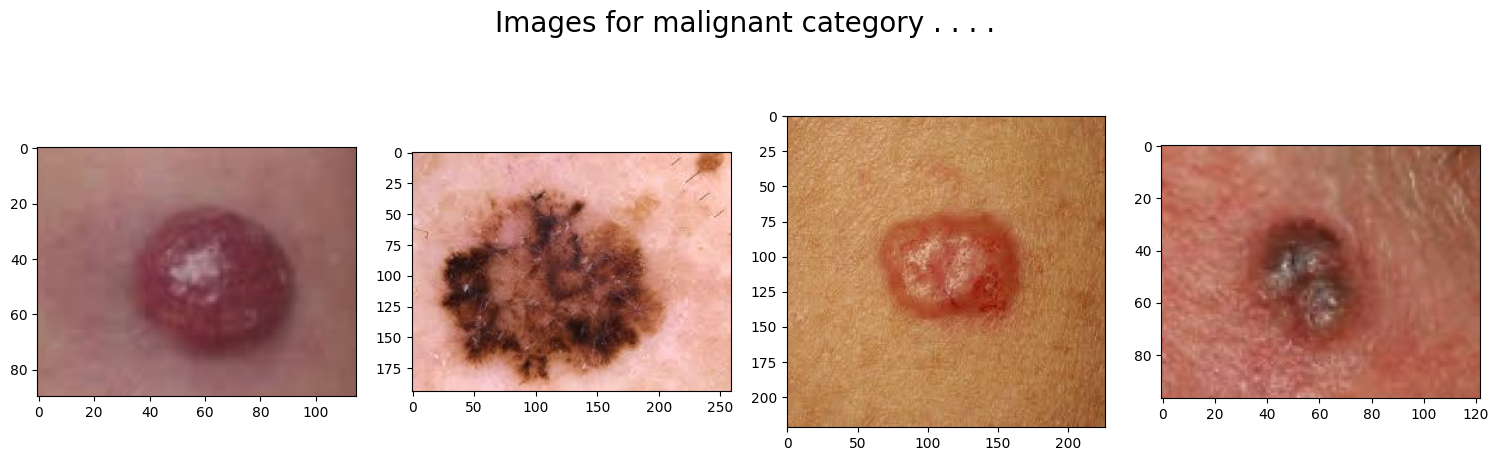

In [6]:
for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [7]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape

((178,), (32,))

In [8]:
# def decode_image(filepath, label=None):
#     img = tf.io.read_file(filepath)
#     img = tf.image.decode_jpeg(img)
#     img = tf.image.resize(img, [224, 224])
#     img = tf.cast(img, tf.float32) / 255.0

#     # Convert label to integer if it's not already
#     if label is not None:
#         label = tf.cast(label, tf.int32)

#     return img, label
def decode_image(filepath, label=None):
    # Read image from file
    img = tf.io.read_file(filepath)
    
    # Decode JPEG-encoded image
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure 3 channels
    
    # Resize image to desired dimensions
    img = tf.image.resize(img, [224, 224])
    
    # Normalize pixel values to range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    # Convert label to integer if it's not already
    if label is not None:
        label = tf.cast(label, tf.int32)

    return img, label

In [9]:
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

In [10]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3),
	weights='imagenet',
	include_top=False
)

for layer in pre_trained_model.layers:
	layer.trainable = False

In [11]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


In [12]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['accuracy', 'AUC']
)

In [13]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=20,
					verbose=1)

Epoch 1/20


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 728ms/step - AUC: 0.7194 - accuracy: 0.6652 - loss: 0.6694 - val_AUC: 0.5000 - val_accuracy: 0.5312 - val_loss: 10.0489
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - AUC: 0.8968 - accuracy: 0.8042 - loss: 0.4175 - val_AUC: 0.5000 - val_accuracy: 0.5312 - val_loss: 9.6424
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - AUC: 0.9288 - accuracy: 0.8595 - loss: 0.3338 - val_AUC: 0.5333 - val_accuracy: 0.5312 - val_loss: 4.8964
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 531ms/step - AUC: 0.9277 - accuracy: 0.8674 - loss: 0.3339 - val_AUC: 0.5000 - val_accuracy: 0.5312 - val_loss: 6.9859
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 578ms/step - AUC: 0.9534 - accuracy: 0.9153 - loss: 0.2834 - val_AUC: 0.5333 - val_accuracy: 0.5312 - val_loss: 5.3191
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - AUC: 0.9679 - accuracy: 0.9045 - loss: 0.2419 - val_AUC: 0.5667 - val_accuracy: 0.5312 - val_loss: 4.6109
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 578ms/step - AUC: 0.96

In [14]:
hist_df = pd.DataFrame(history.history)
hist_df.head()


,AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
0,0.778767,0.702247,0.607297,0.500000,0.53125,10.048859
1,0.885062,0.797753,0.444607,0.500000,0.53125,9.642362
2,0.917957,0.837079,0.369575,0.533333,0.53125,4.896441
3,0.928406,0.870786,0.342014,0.500000,0.53125,6.985865
4,0.947239,0.893258,0.301918,0.533333,0.53125,5.319129


In [15]:
test_loss, test_acc, test_auc = model.evaluate(val_ds)
print('Test Accuracy:', test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - AUC: 0.9412 - accuracy: 0.7188 - loss: 0.5428
Test Accuracy: 0.71875


In [16]:
model.save('model.h5')